# Обучение ResNet50 для классификации фруктов и овощей

In [1]:
import zipfile
import os
import shutil
import random
import gdown
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    DRIVE_DIR = os.path.join("/content/drive", "MyDrive")
except ImportError:
    DRIVE_DIR = os.getcwd()

DATASET_DIR = os.path.join(os.getcwd(), "dataset")
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")

TEMP_DIR = os.path.join(os.getcwd(), "temp")
TEMP_TRAIN_DIR = os.path.join(TEMP_DIR, "train")
TEMP_TEST_DIR = os.path.join(TEMP_DIR, "test")

ZIP_PATH = os.path.join(DRIVE_DIR, "dataset_32_classes_splitted.zip")
os.makedirs(DATASET_DIR, exist_ok=True)

Mounted at /content/drive


In [3]:
file_id = "1-1ehpRd0TnwB1hTHQbFHzdf55SrIri4f"
if os.path.exists(ZIP_PATH):
    print("Архив уже добавлен")
else:
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}", os.path.join(os.getcwd(), "dataset_32_classes.zip"), quiet=False
    )

Архив уже добавлен


In [5]:
with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall("./dataset")

## Подготовка данных и методов

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Значения для Normalize были взяты для ImageNet mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
test_data = torchvision.datasets.ImageFolder(root=TEST_DIR, transform=transform)

In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [11]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Отображу изображения, измененные с помощью transform

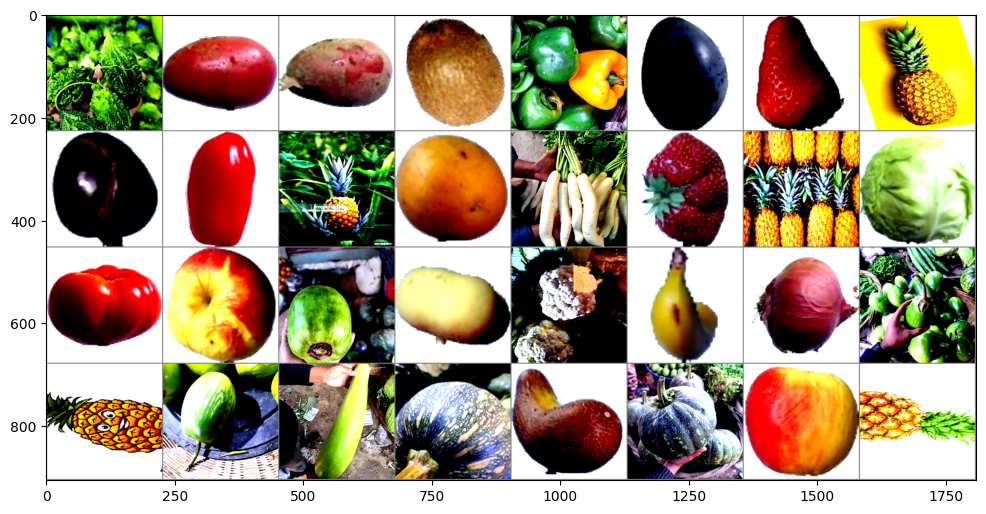

In [12]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(12, 12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

In [13]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [14]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(
            train_dataloader, desc=f"Training, epoch {epoch}", leave=False
        ):
            imgs, labels = imgs.to(device), labels.to(device)

            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat(
                (train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
            )
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat(
                (
                    train_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0),
                )
            )
            train_acc_log.append(
                (pred_classes == labels.cpu()).sum() / labels.cpu().shape[0]
            )

        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(
                val_dataloader, desc=f"Validating, epoch {epoch}", leave=False
            ):
                imgs, labels = imgs.to(device), labels.to(device)

                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat(
                    (val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
                )

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat(
                    (
                        val_epoch_true_hits,
                        (pred_classes == labels.cpu()).sum().unsqueeze(0),
                    )
                )

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(
            val_epoch_true_hits.sum()
            / val_epoch_true_hits.size(0)
            / val_dataloader.batch_size
        )
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:",
            (
                train_epoch_true_hits.sum()
                / train_epoch_true_hits.size(0)
                / train_dataloader.batch_size
            ).item(),
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:",
            (
                val_epoch_true_hits.sum()
                / val_epoch_true_hits.size(0)
                / val_dataloader.batch_size
            ).item(),
        )

In [15]:
def create_model(num_classes, pretrained=True):

    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)

    # Заморозка всех слоев (опционально для трансферного обучения)
    # for param in model.parameters():
    #     param.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

model = create_model(num_classes=len(train_data.classes)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


## Обучение модели

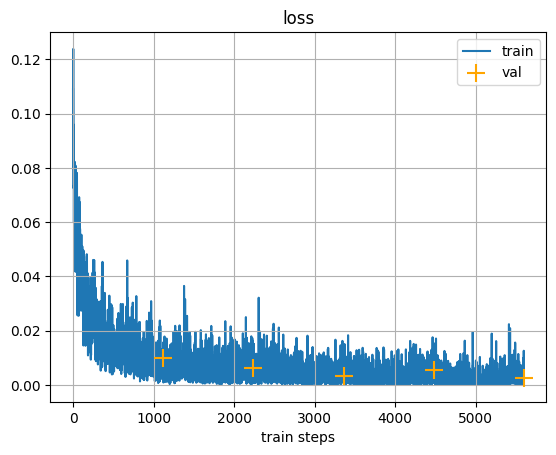

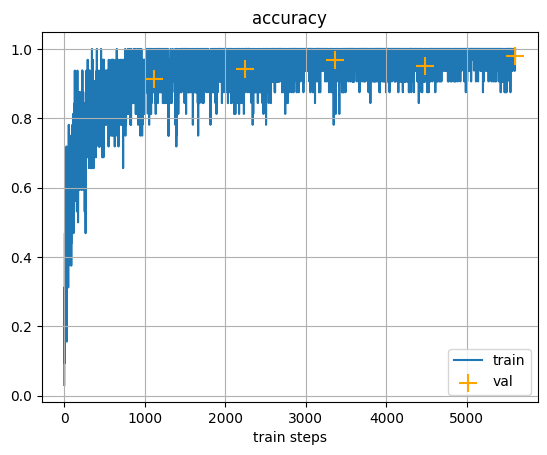

Train loss: 0.002549668774008751
Train acc: 0.9755859375
Val loss: 0.002448523882776499
Val acc: 0.9790178537368774


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, criterion, optimizer, train_loader, test_loader)

**Вывод:**  
Была использована модел ResNet50 с весами для ImageNet. Последний слой модели был заменен на линейный слой, предсказывающий классы используемого датасета.

Полученные метрики:  
Train loss: 0.002549668774008751  
Train acc: 0.9755859375  
Val loss: 0.002448523882776499  
Val acc: 0.9790178537368774  

Сохраню веса обученной модели, чтобы можно было использовать модель потом

In [17]:
torch.save(model.state_dict(), 'resnet50_weights.pth')

In [43]:
# Чтобы использовать после загрузки

# model.load_state_dict(torch.load('fruit_vegetable_weights.pth'))
# model.eval()